# BEE 4750 Final Project Code

**Name**: 

**ID**: 

> **Due Date**
>


## Setup


Running HiGHS 1.12.0 (git hash: 755a8e027): Copyright (c) 2025 HiGHS under MIT licence terms
LP has 36 rows; 36 cols; 72 nonzeros
Coefficient ranges:
  Matrix  [9e-01, 4e+03]
  Cost    [2e+03, 4e+04]
  Bound   [1e+00, 2e+01]
  RHS     [1e+00, 1e+04]
Presolving model
9 rows, 18 cols, 18 nonzeros  0s
9 rows, 18 cols, 18 nonzeros  0s
Presolve reductions: rows 9(-27); columns 18(-18); nonzeros 18(-54) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
          9     2.6815381827e+05 Pr: 0(0) 0s

Performed postsolve
Solving the original LP from the solution after postsolve

Model status        : Optimal
Simplex   iterations: 9
Objective value     :  2.6815381827e+05
P-D objective error :  0.0000000000e+00
HiGHS run time      :          0.00
=== Optimized Routing ===
x_PNA (% per month): [26.3, 26.8, 28.7, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 30.2, 26.8]
x_DNA (%

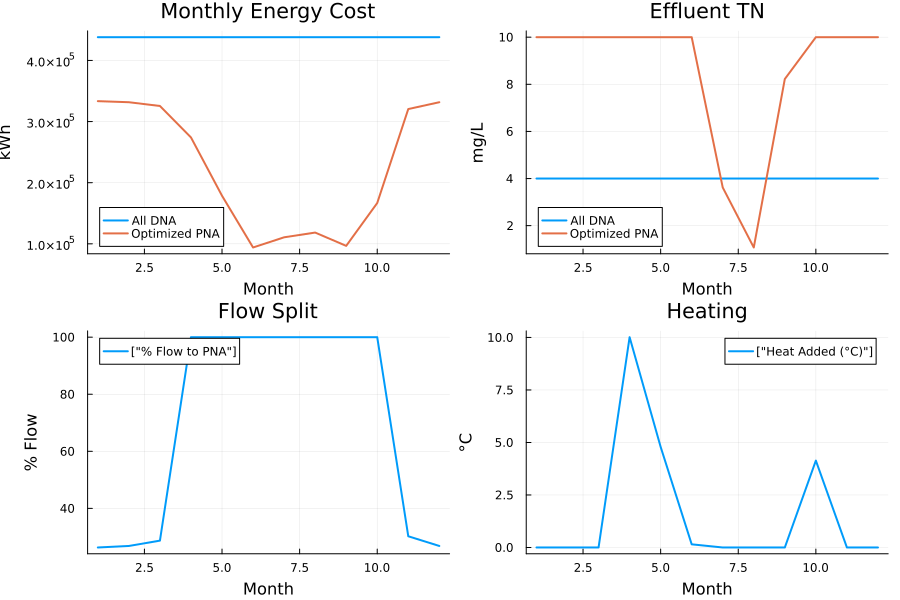

In [17]:
using JuMP
using HiGHS
using Statistics
using Plots

# ----------------------------
# 0. SETTINGS
# ----------------------------
nT = 12                     # months
Q = 100_000.0               # m3/day
Cin = 40.0                  # mg/L
Lin = Q * Cin / 1000.0      # kg N/day

# Days per month
days = fill(365.0 / 12.0, nT)

# Base wastewater temperatures (°C)
T_base = [6.0,6.5,8.0,10.5,14.0,18.0,21.0,22.0,19.0,14.5,9.0,6.5]

# DNA efficiency
eta_DNA_ref = 0.90

# PNA parameters
theta = 1.07
T_ref = 20.0
PNA_daily_limit = 10000.0   # max kg N/day through PNA

# Energy costs
e_DNA = fill(4.0, nT)
e_PNA = fill(1.0, nT)
heat_energy_per_deg = 0.006
c_elec = 0.10

# TN target
TN_target = 10.0  # mg/L

# Heating bounds
M_heat = 20.0

# ----------------------------
# 1. Helper: linearized PNA efficiency
# ----------------------------
eta_base = [min(max(theta^(T_base[m]-T_ref)*0.85,0.01),0.99) for m in 1:nT]  # base efficiency
Δ = 1.0
slopes = [(min(max(theta^(T_base[m]+Δ-T_ref)*0.85,0.01),0.99) -
           min(max(theta^(T_base[m]-Δ-T_ref)*0.85,0.01),0.99)) / (2*Δ) for m in 1:nT]

# ----------------------------
# 2. LP model (optimized routing)
# ----------------------------
model = Model(HiGHS.Optimizer)

@variables(model,
    begin
        0 <= x_DNA[m=1:nT] <= 1
        0 <= x_PNA[m=1:nT] <= 1
        0 <= heat_deg[m=1:nT] <= M_heat
    end
)


# commented out for the time being to exclude operating costs

#= # binary variable 
@variable(model, yP, Bin)  # 1 if PNA is built, 0 otherwise

# linking yP and x_PNA (x_PNA can only exist as a positive vlaue is yP = 1)
@constraint(model, [m=1:nT], x_PNA[m] <= yP)

# annual Capex value 
capex_total = 4_700_000
n= 20.0 # plant lifetime
r = 0.06 # discount rate

# capital return factor
CRF = ((r)*(1+r)^n)/((1+r)^n-1)
capex_PNA_daily = capex_total*CRF*365 =#


# Routing constraint
@constraint(model, [m=1:nT], x_DNA[m] + x_PNA[m] == 1.0)

# PNA daily limit
@constraint(model, [m=1:nT], x_PNA[m]*Lin <= PNA_daily_limit)

# N removed
@expression(model, R_DNA[m=1:nT], eta_DNA_ref * x_DNA[m] * Lin)
@expression(model, R_PNA[m=1:nT], x_PNA[m]*Lin*eta_base[m] + slopes[m]*Lin*heat_deg[m])

# Effluent TN (mg/L)
@expression(model, Ceff[m=1:nT], (Lin - R_DNA[m] - R_PNA[m]) / Q * 1000)
@constraint(model, [m=1:nT], Ceff[m] <= TN_target)

# Energy
@expression(model, E_DNA[m=1:nT], e_DNA[m] * R_DNA[m])
@expression(model, E_PNA[m=1:nT], e_PNA[m] * R_PNA[m])
@expression(model, E_heat[m=1:nT], heat_deg[m] * heat_energy_per_deg * Q)
@expression(model, E_total[m=1:nT], E_DNA[m] + E_PNA[m] + E_heat[m])
#@expression(model, Cost_energy, capex_PNA_daily*yP + sum(days[m]*c_elec*E_total[m] for m in 1:nT))
@expression(model, Cost_energy, sum(days[m]*c_elec*E_total[m] for m in 1:nT))

# Objective: minimize annual energy cost
@objective(model, Min, Cost_energy)

optimize!(model)

# ----------------------------
# 3. Results
# ----------------------------
xPNA_val = [value(x_PNA[m]) for m in 1:nT]
xDNA_val = [value(x_DNA[m]) for m in 1:nT]
heat_val = [value(heat_deg[m]) for m in 1:nT]
Ceff_val = [value(Ceff[m]) for m in 1:nT]
Cost_opt = value(Cost_energy)
E_total_val = [value(E_total[m]) for m in 1:nT]

println("=== Optimized Routing ===")
println("x_PNA (% per month): ", round.(xPNA_val.*100,digits=1))
println("x_DNA (% per month): ", round.(xDNA_val.*100,digits=1))
println("Heat added (°C per month): ", round.(heat_val,digits=2))
println("Effluent TN (mg/L per month): ", round.(Ceff_val,digits=2))
println("Annual energy cost (dollars): ", round(Cost_opt,digits=2))

# ----------------------------
# 4. Baseline: all DNA
# ----------------------------
R_DNA_base = [eta_DNA_ref*Lin for m in 1:nT]
R_PNA_base = [0.0 for m in 1:nT]
Ceff_base = [(Lin - R_DNA_base[m] - R_PNA_base[m])/Q*1000 for m in 1:nT]
E_DNA_base = [e_DNA[m]*R_DNA_base[m] for m in 1:nT]
E_PNA_base = [0.0 for m in 1:nT]
E_heat_base = [0.0 for m in 1:nT]
E_total_base = [E_DNA_base[m] + E_PNA_base[m] + E_heat_base[m] for m in 1:nT]
Cost_base = sum(days[m]*c_elec*E_total_base[m] for m in 1:nT)

# Baseline: all flow to DNA
R_DNA_base = [eta_DNA_ref * Lin for m in 1:nT]
R_PNA_base = [0.0 for m in 1:nT]

# Effluent TN
Ceff_base = [(Lin - R_DNA_base[m] - R_PNA_base[m])/Q*1000 for m in 1:nT]

# Energy usage
E_DNA_base = [e_DNA[m] * R_DNA_base[m] for m in 1:nT]
E_PNA_base = [0.0 for m in 1:nT]
E_heat_base = [0.0 for m in 1:nT]
E_total_base = [E_DNA_base[m] + E_PNA_base[m] + E_heat_base[m] for m in 1:nT]

# Annual energy cost
Cost_annual_DNA = sum(days[m] * c_elec * E_total_base[m] for m in 1:nT)
println("Annual energy cost (all DNA, dollars): ", round(Cost_annual_DNA,digits=2))


# ----------------------------
# 5. Plotting
# ----------------------------
months = 1:12

# Monthly energy cost
plot(months, [E_total_base.*days, E_total_val.*days], 
    labels=["All DNA" "Optimized PNA"], xlabel="Month", ylabel="Daily energy cost (kWh/day * days)",
    title="Monthly Energy Cost", lw=2)

# Effluent TN
plot(months, [Ceff_base, Ceff_val],
    labels=["All DNA" "Optimized PNA"], xlabel="Month", ylabel="Effluent TN (mg/L)",
    title="Monthly Effluent TN", lw=2)

# % flow to PNA
plot(months, xPNA_val.*100,
    labels=["% Flow to PNA"], xlabel="Month", ylabel="% Flow to PNA",
    title="Monthly Flow Split", lw=2, marker=:circle)

# Heat added
plot(months, heat_val,
    labels=["Heat Added (°C)"], xlabel="Month", ylabel="Heat Added (°C)",
    title="Monthly Heating Decisions", lw=2, marker=:square)

# Optionally combine into one grid
plot1 = plot(months, [E_total_base.*days, E_total_val.*days], labels=["All DNA" "Optimized PNA"], lw=2, title="Monthly Energy Cost", xlabel="Month", ylabel="kWh")
plot2 = plot(months, [Ceff_base, Ceff_val], labels=["All DNA" "Optimized PNA"], lw=2, legend=:bottomleft, title="Effluent TN", xlabel="Month", ylabel="mg/L")
plot3 = plot(months, xPNA_val.*100, labels=["% Flow to PNA"], lw=2, title="Flow Split", xlabel="Month", ylabel="% Flow")
plot4 = plot(months, heat_val, labels=["Heat Added (°C)"], lw=2, title="Heating", xlabel="Month", ylabel="°C")

plot(plot1, plot2, plot3, plot4, layout=(2,2), size=(900,600))
# Monthly mean wastewater temperature
#T_mean = T_base  # or measured average per month

#months = 1:12

#plot(months, xPNA_val .* 100, lw=2, marker=:circle, label="% Flow to PNA", xlabel="Month",
#    ylabel="% Flow / Heat (°C)", title="Seasonal Trade-off: Flow vs Temperature")
#plot!(months, heat_val, lw=2, marker=:square, label="Heat added (°C)")
#plot!(months, T_mean, lw=2, linestyle=:dash, label="Influent Temp (°C)", color=:black)














